In [ ]:
#Importing All the libraries import itertools
import pandas as pd 
import numpy as np
import os
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,GRU,SimpleRNN, RNN, Input, Bidirectional
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau, LearningRateScheduler
from sklearn.model_selection import GroupKFold
from tensorflow.keras.optimizers.schedules import ExponentialDecay 
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt 
plt.style.use('fivethirtyeight') 
import warnings
warnings.simplefilter(action='ignore', category= FutureWarning) 

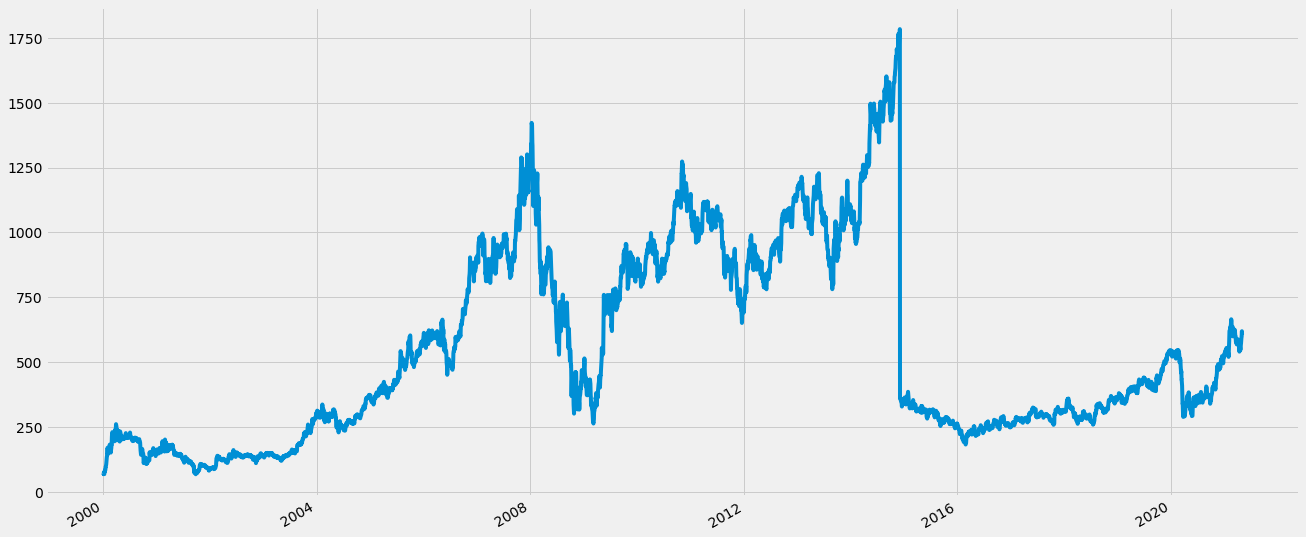

In [ ]:
#Defining the Hyperparamete
# general settings class CFG:
class CFG:
    data_folder = '../input/tsdata-1/' 
    img_dim1 = 20
    img_dim2 = 10
    nepochs = 6
    seed = 42
    EPOCH = 300
    bsize = 16
    BATCH_SIZE = 1024

# adjust the parameters for displayed figures 
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})

def seed_everything(seed: int = 42) -> None:
    np.random.seed(seed) 
    os.environ["PYTHONHASHSEED"] = str(seed)

seed_everything(CFG.seed)
 
#Defining the Evaluation Criteria 
def my_rmse(x,y):
    return(np.round( np.sqrt(mse(x,y)) ,4))

#Loading Dataset
def create_dataset(dataset, look_back, look_ahead):
    xdat, ydat = [], []
    for i in range(len(df) - look_back -look_ahead):
      xdat.append(df[i:i+ look_back ,0])
      ydat.append(df[i+ look_back : i + look_back + look_ahead,0]) 
    xdat, ydat = np.array(xdat), np.array(ydat).reshape(-1,look_ahead) 
    return xdat, ydat

def prepare_split(xdat, ydat, cutoff = 5000, timesteps = 50):
    xtrain, xvalid = xdat[:cutoff,:], xdat[cutoff:,]
    ytrain, yvalid = ydat[:cutoff,:], ydat[cutoff:,]

# reshape into [batch size, time steps, dimensionality] 
    xtrain = xtrain.reshape(-1, timesteps, 1)
    xvalid = xvalid.reshape(-1, timesteps, 1) 
    return xtrain, ytrain, xvalid, yvalid
# load the dataset stock_name = 'ICICIBANK'
df = pd.read_csv('/content/ICICIBANK.csv', usecols = ['Date', 'VWAP']) 
df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date", inplace=True) 
df.VWAP.plot(xlabel = '')


In [ ]:
#Data Preprocessing 
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

# use 50 historical observations, predict 1 step ahead 
look_back = 50
look_ahead = 1
xdat, ydat = create_dataset(df, look_back = look_back, look_ahead = look_ahead)
 
# We only want to forecast a single value for each series => target is a column
print(xdat.shape, ydat.shape)


(5255, 50) (5255, 1)


In [ ]:
xtrain, ytrain, xvalid, yvalid = prepare_split(xdat, ydat, cutoff = 5000, timesteps = look_back)
print(xtrain.shape, xvalid.shape, ytrain.shape, yvalid.shape)



(5000, 50, 1) (255, 50, 1) (5000, 1) (255, 1)


In [ ]:
#Creating the model 
def create_model1():

    model=Sequential() 
    model.add(SimpleRNN(10,input_shape= [None,1])) 
    model.add(Dense(1))

    model.compile(loss='mean_squared_error',optimizer='adam') 
    return model

model1 = create_model1() 
model1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10)                120       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 5, mode = 'min', verbose = 1, restore_best_weights = True)

model1.fit(xtrain, ytrain, validation_data=(xvalid, yvalid),
epochs = CFG.nepochs, batch_size = CFG.bsize, callbacks=[ early_stop])
 


Epoch 1/6
313/313 [==============================] - 4s 9ms/step - loss: 0.0016 - val_loss: 1.9739e-04
Epoch 2/6
313/313 [==============================] - 3s 8ms/step - loss: 4.6394e-04 - val_loss: 1.2294e-04
Epoch 3/6
313/313 [==============================] - 3s 8ms/step - loss: 4.1163e-04 - val_loss: 8.5347e-05
Epoch 4/6
313/313 [==============================] - 3s 8ms/step - loss: 3.6660e-04 - val_loss: 8.8743e-05
Epoch 5/6
313/313 [==============================] - 3s 9ms/step - loss: 3.6281e-04 - val_loss: 6.4650e-05
Epoch 6/6
313/313 [==============================] - 3s 9ms/step - loss: 3.4209e-04 - val_loss: 6.2882e-05
Epoch 6: early stopping


In [ ]:
# predict and calculate RMSE 
y_pred1 = model1.predict(xvalid)
y_pred1 = scaler.inverse_transform(y_pred1) 
yvalid1 = scaler.inverse_transform(yvalid)


8/8 [==============================] - 0s 4ms/step


In [ ]:
print('RMSE: ' + str(my_rmse(y_pred1, yvalid1)))

RMSE: 24.0944


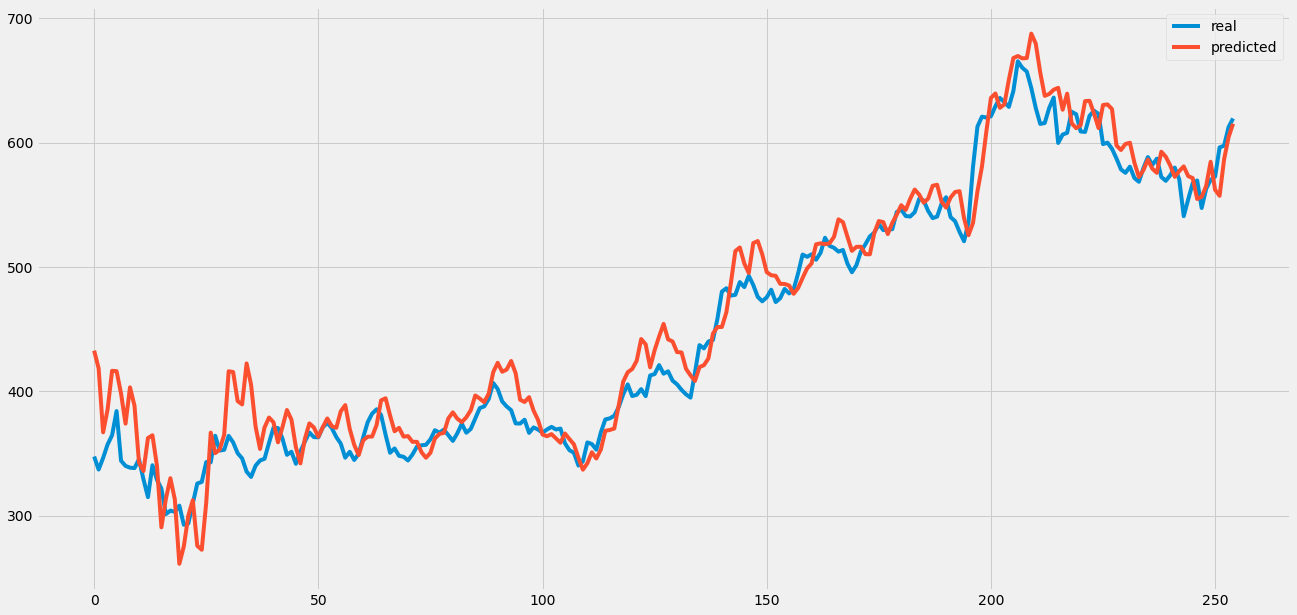

In [ ]:
plt.plot(scaler.inverse_transform(yvalid), label = 'real') 
plt.plot(y_pred1, label = 'predicted')
plt.ylabel('') 
plt.legend() 
plt.show()


In [ ]:
#Creating the model 02 
def create_model2():
    model=Sequential()
    model.add(SimpleRNN(10,input_shape= [None,1], return_sequences = True))

    model.add(SimpleRNN(10,input_shape= [None,1])) 
    model.add(Dense(1))
 
    model.compile(loss='mean_squared_error',optimizer='adam') 
    return model

model2 = create_model2() 
model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, None, 10)          120       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 10)                210       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.fit(xtrain, ytrain, validation_data=(xvalid, yvalid),
epochs = CFG.nepochs, batch_size = CFG.bsize, callbacks=[ early_stop])

y_pred2 = model2.predict(xvalid)
y_pred2 = scaler.inverse_transform(y_pred2)
print('RMSE: ' + str(my_rmse(y_pred2, scaler.inverse_transform(yvalid))
))

 


Epoch 1/6
313/313 [==============================] - 10s 24ms/step - loss: 0.0010 - val_loss: 8.7642e-05
Epoch 2/6
313/313 [==============================] - 6s 18ms/step - loss: 3.0235e-04 - val_loss: 6.7881e-05
Epoch 3/6
313/313 [==============================] - 6s 18ms/step - loss: 2.6694e-04 - val_loss: 1.2346e-04
Epoch 4/6
313/313 [==============================] - 7s 22ms/step - loss: 2.9334e-04 - val_loss: 1.0218e-04
Epoch 5/6
313/313 [==============================] - 11s 36ms/step - loss: 2.8331e-04 - val_loss: 5.9100e-05
Epoch 6/6
313/313 [==============================] - 7s 22ms/step - loss: 2.6467e-04 - val_loss: 4.8191e-05
Epoch 6: early stopping
8/8 [==============================] - 0s 6ms/step
RMSE: 16.0548


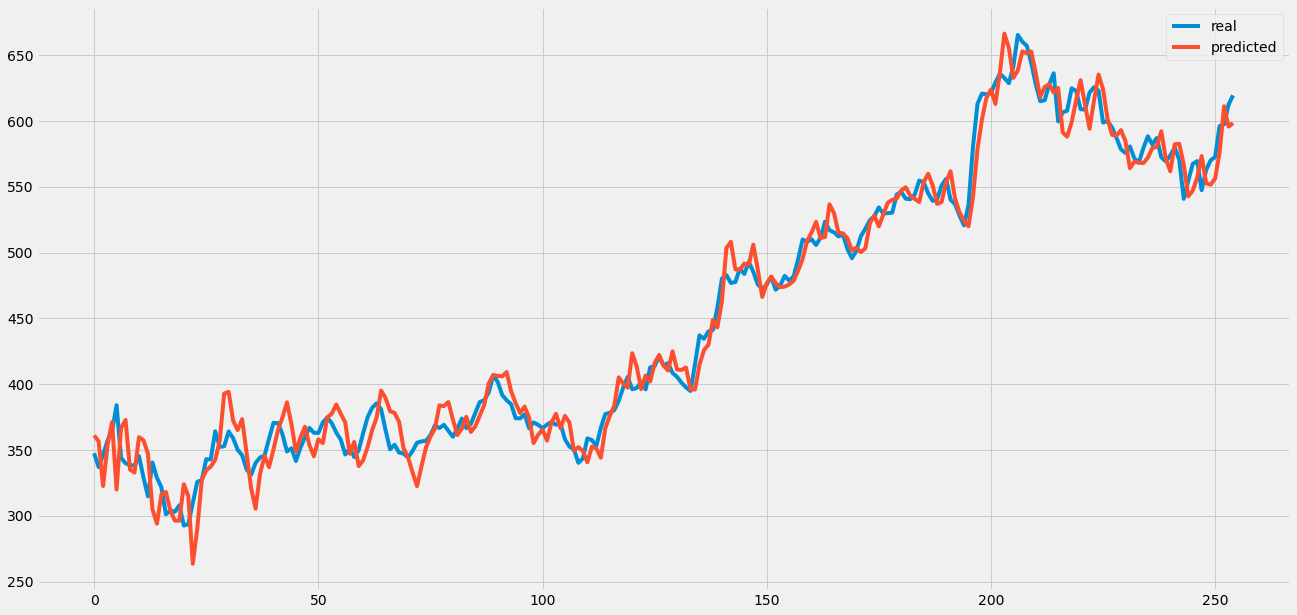

In [ ]:
plt.plot(scaler.inverse_transform(yvalid), label = 'real') 
plt.plot(y_pred2, label = 'predicted')
plt.ylabel('') 
plt.legend() 
plt.show()


In [ ]:
#Creating the model 03
def create_model3(out_dim): 
    model=Sequential()
    model.add(SimpleRNN(10,input_shape= [None,1], return_sequences = True))
 
    model.add(SimpleRNN(10,input_shape= [None,1])) 
    model.add(Dense(out_dim))

    model.compile(loss='mean_squared_error',optimizer='adam') 
    return model

model3 = create_model3(out_dim = look_ahead) 
model3.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, None, 10)          120       
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model3.fit(xtrain, ytrain, validation_data=(xvalid, yvalid),
epochs = CFG.nepochs, batch_size = CFG.bsize, callbacks=[ early_stop])

y_pred3 = model3.predict(xvalid)
y_pred3 = scaler.inverse_transform(y_pred3)


Epoch 1/6
313/313 [==============================] - 7s 19ms/step - loss: 0.0189 - val_loss: 6.5115e-04
Epoch 2/6
313/313 [==============================] - 5s 17ms/step - loss: 0.0011 - val_loss: 2.0360e-04
Epoch 3/6
313/313 [==============================] - 5s 17ms/step - loss: 7.3143e-04 - val_loss: 1.4001e-04
Epoch 4/6
313/313 [==============================] - 5s 16ms/step - loss: 5.7016e-04 - val_loss: 3.0463e-04
Epoch 5/6
313/313 [==============================] - 6s 19ms/step - loss: 4.6658e-04 - val_loss: 3.6693e-04
Epoch 6/6
313/313 [==============================] - 6s 18ms/step - loss: 4.1818e-04 - val_loss: 7.7428e-05
Epoch 6: early stopping
8/8 [==============================] - 0s 8ms/step


In [ ]:
print('RMSE: ' + str(my_rmse(y_pred3, scaler.inverse_transform(yvalid))
))


RMSE: 43.7613


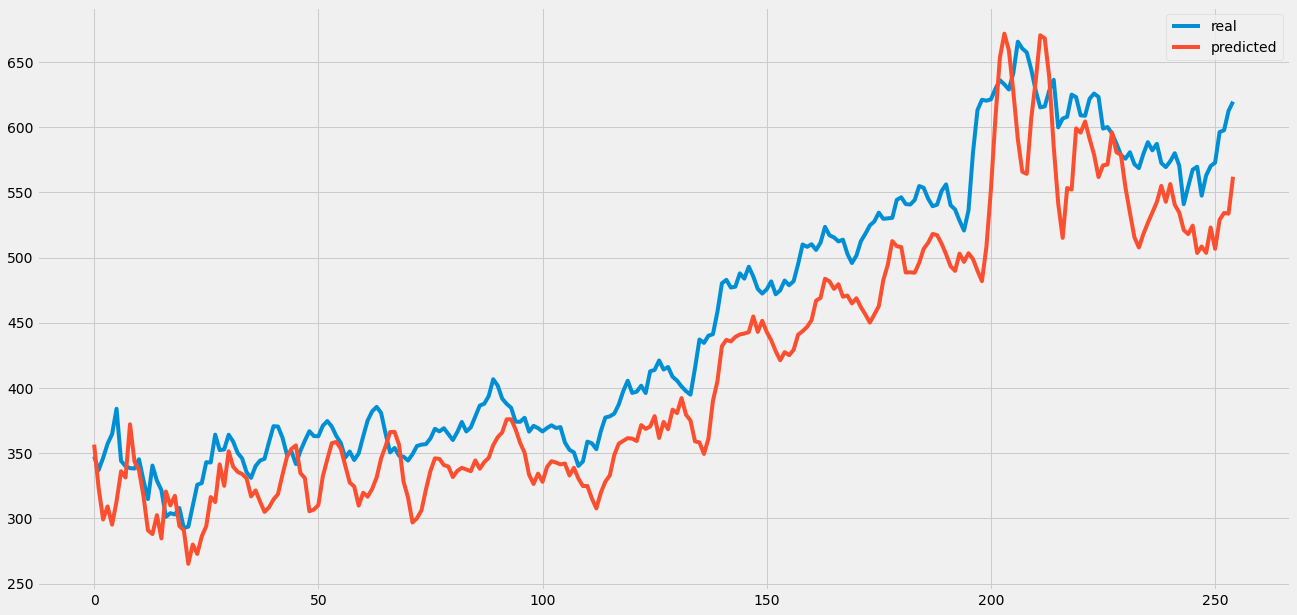

In [ ]:
plt.plot(scaler.inverse_transform(yvalid), label = 'real') 
plt.plot(y_pred3, label = 'predicted')
plt.ylabel('') 
plt.legend() 
plt.show()


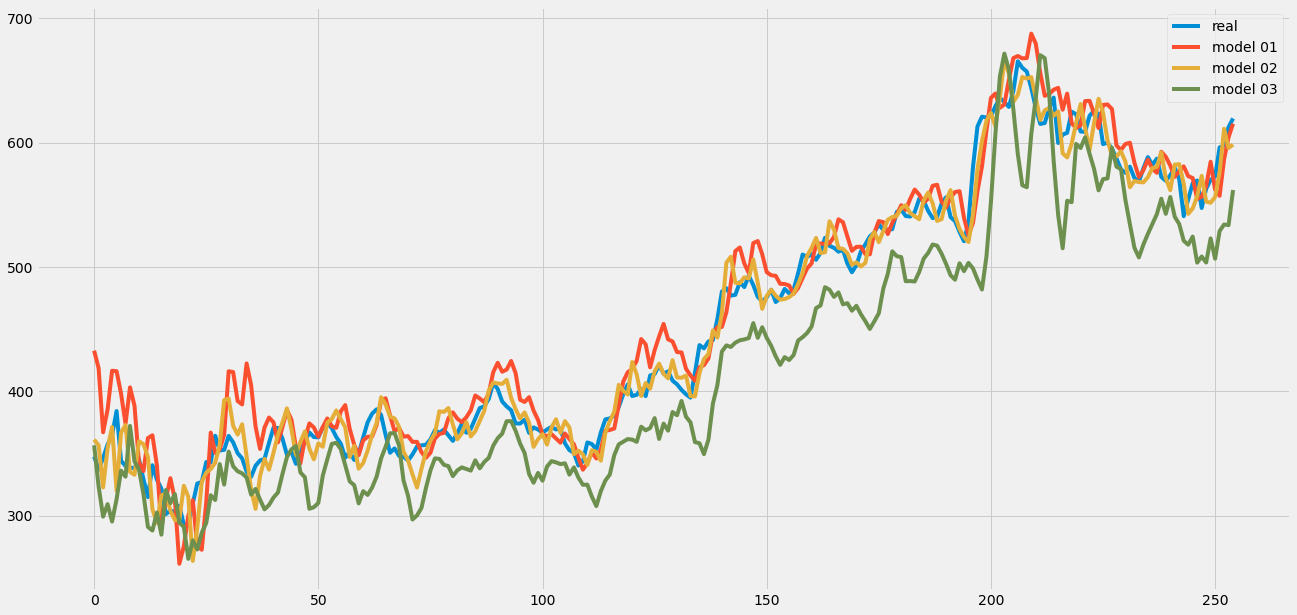

In [ ]:
plt.plot(scaler.inverse_transform(yvalid), label = 'real') 
plt.plot(y_pred1, label = 'model 01')
plt.plot(y_pred2, label = 'model 02') 
plt.plot(y_pred3, label = 'model 03') 
plt.ylabel('')
plt.legend() 
plt.show()
